In [1]:
import os
from sound.sound_eval import eval_sound
import numpy as np
from matplotlib import pyplot as plt
import pydub
from time_series.anomaly_detection import polyreg_outliar_mse, lof
from time_series.smoothening_functions import power_smooth, llr_smooth, ewma_bias_corrected, kaiser_wind,derivative

In [2]:
def eval_linreg(arr, n, linreg):
    arr = np.array(arr).reshape((len(arr),))
    windows = []
    labels = []
    for i in range(len(arr)-n):
        windows.append(arr[i:i+n])
        labels.append(arr[i+n])
    return (linreg.predict(windows) - labels)**2

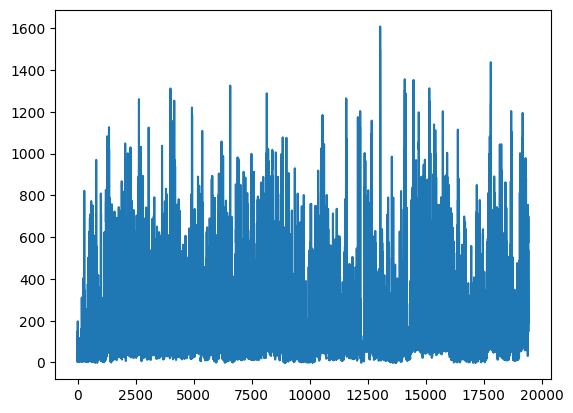

In [3]:
a = pydub.AudioSegment.from_mp3("data/custom_game.mp3")
        
y = np.array(a.get_array_of_samples())
data_binr, data_rmsr, _ = eval_sound(y,a)
plt.plot(data_binr)
plt.show()

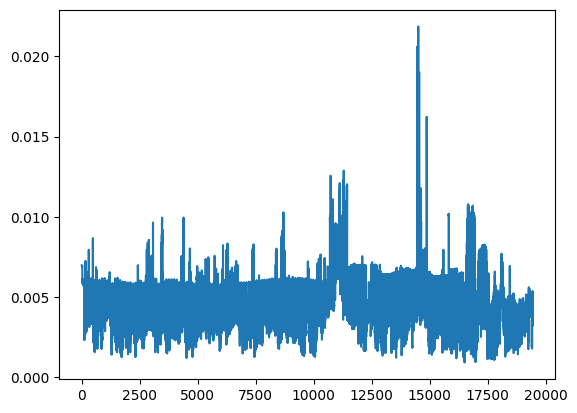

In [4]:
singl_frm = np.loadtxt("data/custom_game.csv", delimiter = ",")
plt.plot(singl_frm)
plt.show()

In [13]:
def get_anomls(arr, signal, thr):
    segms = []
    
    
    print(thr)
    i = 0
    while i < len(arr):
        if arr[i] == 0:
            i+=1
            continue
        start = i
        while i < len(arr) and arr[i]>thr:
            i+=1
        
        
        
        segms.append([start, np.max(np.array(signal[i-180:i+180])), i])
        i+=1
    return segms

In [19]:
labels = [[315,355],[2144,2215],[3328, 3355],[3150,3215],[2225, 2330],[3845, 3945],[2855, 2940],[4855, 4935]]
video_legnth  = 60*53+59

In [84]:
from sklearn.metrics import precision_score, recall_score, average_precision_score
def get_ap(tot_length, res, labels,start = 0, ends = None):
    if not ends:
        ends = len(res)
    ground_truth = np.zeros((tot_length*6,))
    for l in labels:
        strt, end = l[0], l[1]
        strt = (strt%100)+60*int(strt/100)
        end = (end%100)+60*int(end/100)
        for i in range(strt*6-60,end*6+60):
            ground_truth[i] = 1
    
    
        
    return average_precision_score(ground_truth[start:ends], res)
def get_ap_at_k(tot_length, segms, labels):
    segms = reversed(segms)
    ground_truth = np.zeros((tot_length*6,))
    starts = np.zeros((tot_length*6,))
    ends = np.zeros((tot_length*6,))
    for l in labels:
        strt, end = l[0], l[1]
        strt = (strt%100)+60*int(strt/100)
        end = (end%100)+60*int(end/100)
        for i in range(strt*6-60,end*6+60):
            ground_truth[i] = 1
        starts[strt*6-10:strt*6+10] = 1
        ends[end*6-10: end*6+10] = 1
    count_starts = 0
    sums_starts = 0
    count_end = 0
    sums_end = 0
    count_coverage = 0
    sums_coverage = 0
    for i, s in enumerate(segms):
        if i > 6:
            break
        # Get starts:
        if np.sum(starts[s[0]-90:s[0]+60])>0:
            print("start ",i+1)
            count_starts += 1
            sums_starts += count_starts/(i+1)
        
        # Get ends:
        if np.sum(ends[s[-1]-60:s[-1]+90])>0:
            print("end ",i+1)
            count_end += 1
            sums_end += count_end/(i+1)
        
        if np.mean(ground_truth[s[0]:s[-1]])>0.45:
            print("coverage ",i+1)
            count_coverage += 1
            sums_coverage += count_coverage/(i+1)
    
    return sums_starts/max(1,count_starts), sums_end/max(1,count_end), sums_coverage/max(1,count_coverage)
        


19422


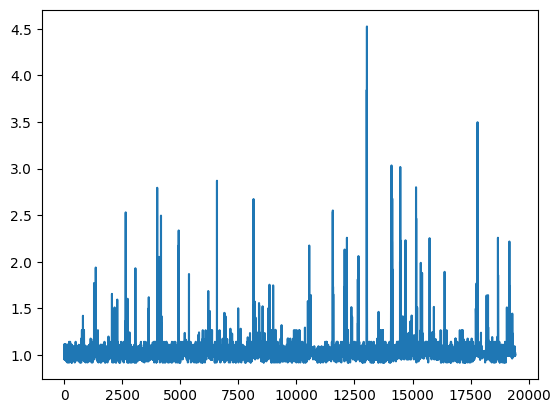

2.489144314323516


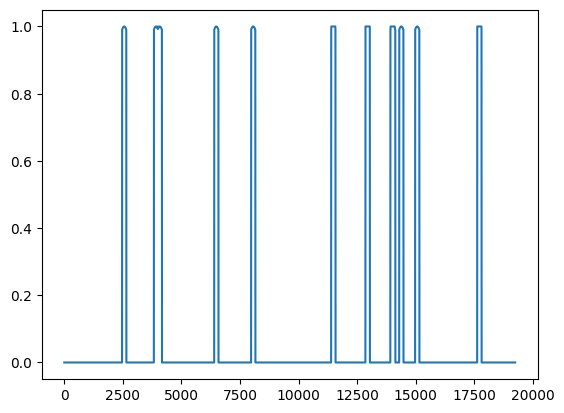

19243
0.5
10
6.852777777777778 7.352777777777778 2.530394164637747
10.622222222222222 11.575 2.7942693370592866
17.772222222222222 18.272222222222222 2.8697530592634584
22.147222222222222 22.647222222222222 2.67341522671958
31.633333333333333 32.147222222222226 2.550432867895903
35.69722222222222 36.21944444444444 4.5253369026569645
38.65277777777778 39.23888888888889 3.0339598676175346
39.702777777777776 40.202777777777776 3.0175004913551455
41.58888888888889 42.08888888888889 2.79956231867851
48.94722222222222 49.46111111111111 3.4977660193740707
AP: 0.28731825563341007
6.852777777777778 7.352777777777778 2.530394164637747
31.633333333333333 32.147222222222226 2.550432867895903
22.147222222222222 22.647222222222222 2.67341522671958
10.622222222222222 11.575 2.7942693370592866
41.58888888888889 42.08888888888889 2.79956231867851
17.772222222222222 18.272222222222222 2.8697530592634584
39.702777777777776 40.202777777777776 3.0175004913551455
38.65277777777778 39.23888888888889 3.033959

In [81]:
# segms = SWIDE_ours(kaiser_wind(lof(np.array(data_binr), 360),180,4), 5)
print(len(data_binr))
interm = np.array(data_binr)
r = 480
interm  = lof(interm, r )
signal  = interm

plt.plot(interm)
plt.show()
print(np.quantile(interm, 0.999))
interm = interm >= np.quantile(interm, 0.999) + 0
interm  = kaiser_wind(interm, 180, 0.2 )
interm[interm>1] = 1
plt.plot(interm)
plt.show()

print(len(interm))
segms = get_anomls(interm, signal, 0.5)
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    # s[0]-=r/2
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])
segms.sort(key=lambda x: x[1])
print("============")
print("AP:", get_ap(video_legnth, interm, labels))
for s in segms:
    # s[0]-=180
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])
print(get_ap_at_k(video_legnth, segms, labels))

19434


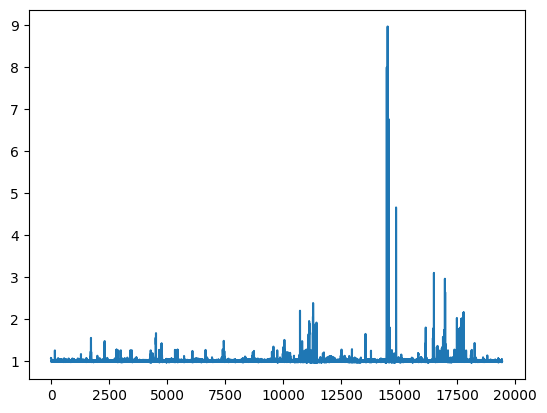

1.6390548133519307


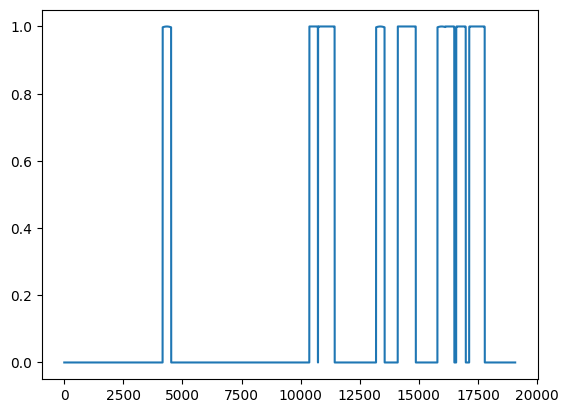

0.5
19075
8
11.305555555555555 12.555555555555555 1.6650031524285258
28.544444444444444 29.8 2.198225197454372
29.566666666666666 31.766666666666666 2.3815969216531685
36.38611111111111 37.63611111111111 1.6463025987043816
38.93333333333333 41.3 4.656937685755249
43.59722222222222 45.827777777777776 3.0994918856780505
45.8 47.172222222222224 2.959625102437358
47.327777777777776 49.40277777777778 2.158442067636067
AP: 0.1920771391053263
36.38611111111111 37.63611111111111 1.6463025987043816
11.305555555555555 12.555555555555555 1.6650031524285258
47.327777777777776 49.40277777777778 2.158442067636067
28.544444444444444 29.8 2.198225197454372
29.566666666666666 31.766666666666666 2.3815969216531685
45.8 47.172222222222224 2.959625102437358
43.59722222222222 45.827777777777776 3.0994918856780505
38.93333333333333 41.3 4.656937685755249
start  1
end  5
coverage  5
end  6
(1.0, 0.26666666666666666, 0.2)


In [82]:
# segms = SWIDE_ours(kaiser_wind(lof(np.array(data_binr), 360),180,4), 5)
print(len(singl_frm))
interm = np.array(singl_frm)
r = 240
interm  = lof(interm, r )
signal  = interm

plt.plot(interm)
plt.show()
print( np.quantile(interm, 0.995))
interm = interm > np.quantile(interm, 0.995) + 0
interm  = kaiser_wind(interm, 360, 0.1 )
interm[interm>1] = 1

plt.plot(interm)
plt.show()
segms = get_anomls(interm, signal, 0.5)
print(len(interm))
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    s[0]-=90
    # s[-1]+=90
    print(s[0]/360, s[-1]/360, s[1])
segms.sort(key=lambda x: x[1])

print("AP:", get_ap(video_legnth, interm, labels, start = 90, ends = len(interm)+90))
print("============")
for s in segms:
    # s[0]-=180
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])
print(get_ap_at_k(video_legnth, segms, labels))

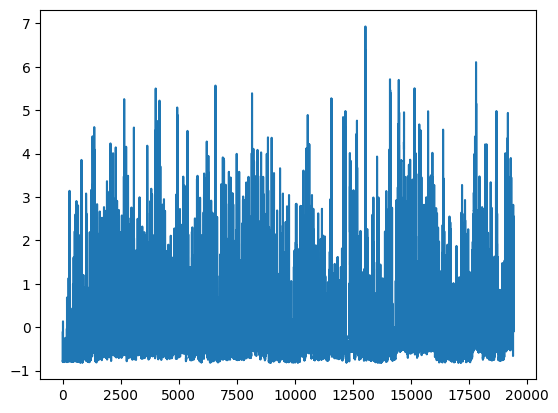

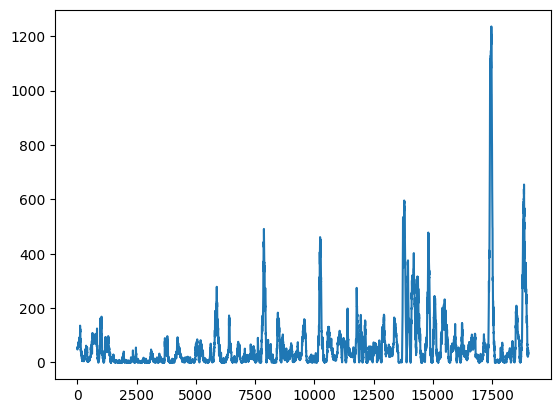

231.3183899678101


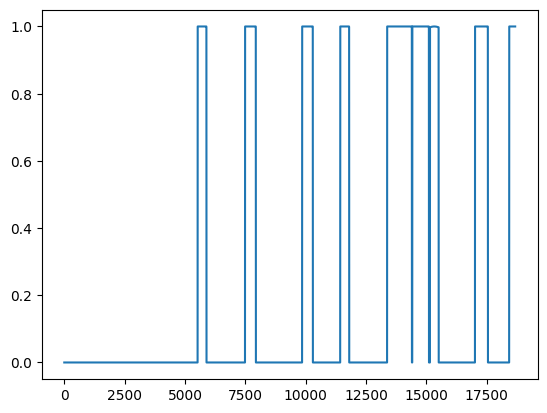

0.5
9
16.33888888888889 17.352777777777778 1.1210619597730642
21.791666666666668 23.033333333333335 1.0386609208599988
28.358333333333334 29.58888888888889 1.214044405885127
32.74166666666667 33.769444444444446 1.2054898385142976
38.13611111111111 40.983333333333334 8.966695183250264
41.03055555555556 42.94444444444444 1.15470798855486
43.06388888888889 44.06388888888889 1.0820117171144166
48.24444444444445 49.727777777777774 2.025998842641331
52.17777777777778 52.87222222222222 1.1337493403437378
AP: 0.3178591622831885
21.791666666666668 23.033333333333335 1.0386609208599988
43.06388888888889 44.06388888888889 1.0820117171144166
16.33888888888889 17.352777777777778 1.1210619597730642
52.17777777777778 52.87222222222222 1.1337493403437378
41.03055555555556 42.94444444444444 1.15470798855486
32.74166666666667 33.769444444444446 1.2054898385142976
28.358333333333334 29.58888888888889 1.214044405885127
48.24444444444445 49.727777777777774 2.025998842641331
38.13611111111111 40.98333333333

In [85]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
r = 180
d_interm = sc.fit_transform(X  =np.array(data_binr).reshape(-1,1), y = None)
# d_interm = np.log(np.array(data_binr))
# d_interm = data_binr
plt.plot(d_interm)
plt.show()
unsup_linreg = polyreg_outliar_mse([d_interm.reshape(-1,)],r)
interm = eval_linreg(kaiser_wind(d_interm.reshape(-1,), r+30, 2), r, unsup_linreg)
plt.plot(interm)
plt.show()
print( np.quantile(interm, 0.95))
interm = interm > np.quantile(interm, 0.95) + 0
interm  = kaiser_wind(interm, 360, 0.1 )
interm[interm>1] = 1
plt.plot(interm)
plt.show()
segms = get_anomls(interm, signal, 0.5)
print(len(segms))
# segm_means = [np.mean(np.array(i)) for i in segms]
# print(segm_means)
for s in segms:
    # s[0]-=r/2
    s[0]+=2*r
    s[-1]+=2*r
    print(s[0]/360, s[-1]/360, s[1])
segms.sort(key=lambda x: x[1])
print("============")

print("AP:", get_ap(video_legnth, interm, labels, start = 2*r, ends = len(interm)+2*r ))
for s in segms:
    # s[0]-=180
    # s[-1]+=180
    print(s[0]/360, s[-1]/360, s[1])
print(get_ap_at_k(video_legnth, segms, labels))